## Import required libraries

In [25]:
## Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Split Data
from sklearn.model_selection import train_test_split

# Machine learning models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score,f1_score, roc_curve)
from sklearn.model_selection import GridSearchCV, cross_val_score


## Data Collection: Gather and collect data.

In [26]:

## Data Collection
df = pd.read_csv("../data/Data_Weather.csv")

print("=== Dataset Overview ===")
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1]-1}")
print(f"Number of samples: {df.shape[0]}")
print("\nFirst 5 rows:")
print(df.head())


=== Dataset Overview ===
Dataset shape: (145460, 23)
Number of features: 22
Number of samples: 145460

First 5 rows:
         Date  Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2010-04-30  Adelaide     10.8     21.2       0.0          1.8      6.60   
1  2014-07-22  Adelaide      3.7     19.0       0.0          1.4      7.61   
2  2014-07-23  Adelaide      9.6     15.8       0.0          2.6      7.61   
3  2014-07-24  Adelaide     10.1     15.5      16.6          0.8      7.61   
4  2014-07-25  Adelaide     11.2     16.2       1.8          0.6      7.61   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0         ENE           22.0        ENE  ...        66.0         48.0   
1           N           24.0          N  ...        75.0         32.0   
2          NE           52.0        NNE  ...        35.0         51.0   
3         NNE           50.0         NW  ...        96.0         80.0   
4          NW           30.0        WNW  ...     

## Exploratory data analysis (EDA)

In [27]:
## Exploratory data analysis (EDA)
print("\n=== Column Names ===")
print(df.columns.tolist())

print("\n=== Target Variable Distribution ===")
print(df['RainTomorrow'].value_counts())
print("\nPercentage distribution:")
print(df['RainTomorrow'].value_counts(normalize=True) * 100)

print("\n=== Descriptive Statistics ===")
print(df.describe())

print("\n=== Missing Values ===")
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing_Count'] > 0])



=== Column Names ===
['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']

=== Target Variable Distribution ===
RainTomorrow
No     113583
Yes     31877
Name: count, dtype: int64

Percentage distribution:
RainTomorrow
No     78.085384
Yes    21.914616
Name: proportion, dtype: float64

=== Descriptive Statistics ===
             MinTemp        MaxTemp       Rainfall    Evaporation  \
count  145460.000000  145460.000000  145460.000000  145460.000000   
mean       12.193993      23.221337       2.360898       5.468995   
std         6.365750       7.088124       8.382488       3.161541   
min        -8.500000      -4.800000       0.000000       0.000000   
25%         7.700000      18.000000       0.000000       4.000000   
50%        1

## Displaying the distribution of rainTomorrow in the data

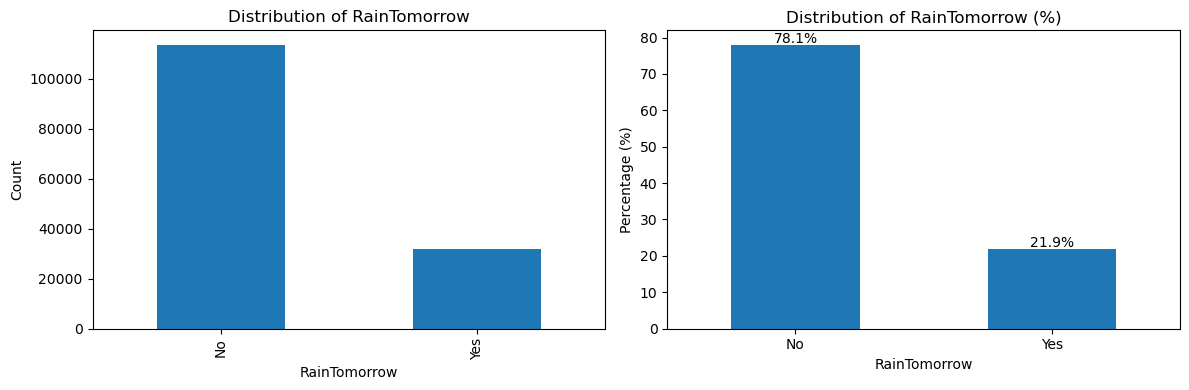

In [28]:

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
df['RainTomorrow'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title("Distribution of RainTomorrow")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("RainTomorrow")

# Percentage plot
dist = df['RainTomorrow'].value_counts(normalize=True) * 100
dist.plot(kind='bar', ax=axes[1])
axes[1].set_ylabel("Percentage (%)")
axes[1].set_title("Distribution of RainTomorrow (%)")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

for i, v in enumerate(dist):
    axes[1].text(i, v + 0.5, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()


## Data Prepocessing - Phase 1 (Before Split)

In [5]:

## Data Prepocessing - Phase 1 (Before Split)
print("\n=== Prepocessing - Phase 1 ===")

# Drop non-informative columns
df_clean = df.drop(columns=['Location', 'Date'], errors='ignore')

# Separate features and target
X = df_clean.drop('RainTomorrow', axis=1)
y = df_clean['RainTomorrow']

# Encode target variable (Yes = 1, No = 0)
y = y.map({'Yes': 1, 'No': 0})

print(f"\nTarget class distribution:")
print(y.value_counts())
print(f"Class imbalance ratio: {y.value_counts()[0]/y.value_counts()[1]:.2f}:1")

# Identify feature types
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# Remove duplicates before split
duplicates_before = X.duplicated().sum()
print(f"\nNumber of duplicates: {duplicates_before}")
X = X.drop_duplicates()
y = y[X.index]
print(f"Shape after removing duplicates: {X.shape}")



=== Prepocessing - Phase 1 ===

Target class distribution:
RainTomorrow
0    113583
1     31877
Name: count, dtype: int64
Class imbalance ratio: 3.56:1

Categorical columns (4): ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
Numerical columns (16): ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

Number of duplicates: 238
Shape after removing duplicates: (145222, 20)


## Data Split

### Separate into 80% training and 20% testing


In [6]:

### Data Split
print("\n=== Data Split ===")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training class distribution:\n{y_train.value_counts()}")
print(f"Test class distribution:\n{y_test.value_counts()}")



=== Data Split ===
Training set size: (116177, 20)
Test set size: (29045, 20)
Training class distribution:
RainTomorrow
0    90681
1    25496
Name: count, dtype: int64
Test class distribution:
RainTomorrow
0    22671
1     6374
Name: count, dtype: int64


# Data Preprocessing - phase 2 (after split)

### Missing value imputation

In [7]:

# Data Preprocessing - phase 2 (after split)

### 1. IMPUTATION - Fit on train, transform both
print("\n=== Data Preprocessing - phase 2  ===")
print("\n Imputing missing values")

# Numerical imputation
num_imputer = SimpleImputer(strategy='median')
X_train[numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = num_imputer.transform(X_test[numerical_cols])

# Categorical imputation
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])


=== Data Preprocessing - phase 2  ===

 Imputing missing values


### Outlier treatment


In [8]:
### 2 Outlier treatment
print("\n Outlier treatment")
for col in numerical_cols:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Apply to both train and test
    X_train[col] = X_train[col].clip(lower=lower_bound, upper=upper_bound)
    X_test[col] = X_test[col].clip(lower=lower_bound, upper=upper_bound)


 Outlier treatment


### Encoding categorical features

In [9]:
### Encoding categorical features
print("\n Encoding categorical features")
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[categorical_cols])

# Transform both sets
encoded_train = encoder.transform(X_train[categorical_cols])
encoded_test = encoder.transform(X_test[categorical_cols])

# Create DataFrames
feature_names = encoder.get_feature_names_out(categorical_cols)
encoded_train_df = pd.DataFrame(encoded_train, columns=feature_names, index=X_train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=feature_names, index=X_test.index)

# Replace categorical with encoded
X_train = X_train.drop(columns=categorical_cols)
X_test = X_test.drop(columns=categorical_cols)
X_train = pd.concat([X_train, encoded_train_df], axis=1)
X_test = pd.concat([X_test, encoded_test_df], axis=1)

print(f"Shape after encoding - Train: {X_train.shape}, Test: {X_test.shape}")


 Encoding categorical features
Shape after encoding - Train: (116177, 62), Test: (29045, 62)


### Normalized or Transformed / Feature scaling


 Scaling numerical features: 


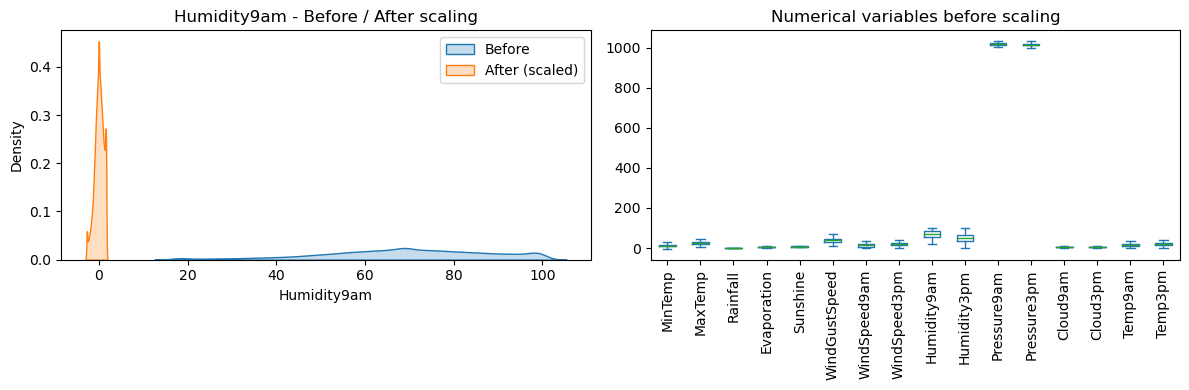

<Figure size 1200x400 with 0 Axes>

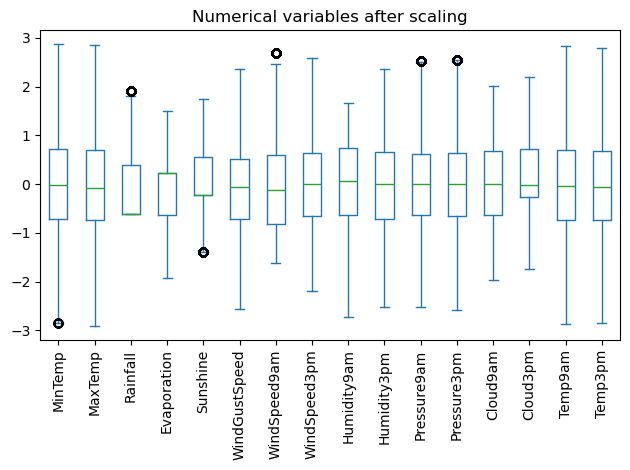

In [10]:
### Normalized or Transformed / Feature scaling
print("\n Scaling numerical features: ")

# Save before scaling for visualization
X_train_before_scaling = X_train[numerical_cols].copy()

scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Visualization of scaling effect
fig, axes = plt.subplots(1, 2, figsize=(12, 4))


sns.kdeplot(X_train_before_scaling["Humidity9am"], label="Before", fill=True, ax=axes[0])
sns.kdeplot(X_train["Humidity9am"], label="After (scaled)", fill=True, ax=axes[0])
axes[0].legend()
axes[0].set_title("Humidity9am - Before / After scaling")


X_train_before_scaling.plot(kind='box', ax=axes[1])
axes[1].set_title("Numerical variables before scaling")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))
X_train[numerical_cols].plot(kind='box')
plt.xticks(rotation=90)
plt.title("Numerical variables after scaling")
plt.tight_layout()
plt.show()

### Feature Selection

In [11]:
### Feature Selection
print("\nFeature selection based on correlation...")
corr_matrix = X_train[numerical_cols].corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.9
features_to_drop = [
    column for column in upper_triangle.columns
    if any(upper_triangle[column] > threshold)
]

print(f"Features to drop (correlation > {threshold}): {features_to_drop}")
print(f"Number of features dropped: {len(features_to_drop)}")

X_train_reduced = X_train.drop(columns=features_to_drop, errors='ignore')
X_test_reduced = X_test.drop(columns=features_to_drop, errors='ignore')

print(f"Shape after feature selection - Train: {X_train_reduced.shape}, Test: {X_test_reduced.shape}")



Feature selection based on correlation...
Features to drop (correlation > 0.9): ['Pressure3pm', 'Temp3pm']
Number of features dropped: 2
Shape after feature selection - Train: (116177, 60), Test: (29045, 60)


### Class Balancing


Balancing classes with SMOTE (just on Train data)...
Before SMOTE - Train class distribution:
RainTomorrow
0    90681
1    25496
Name: count, dtype: int64
Before SMOTE - Train class ratio: RainTomorrow
0    0.780542
1    0.219458
Name: proportion, dtype: float64

After SMOTE - Train class distribution:
RainTomorrow
1    90681
0    90681
Name: count, dtype: int64
After SMOTE - Train class ratio:
RainTomorrow
1    0.5
0    0.5
Name: proportion, dtype: float64


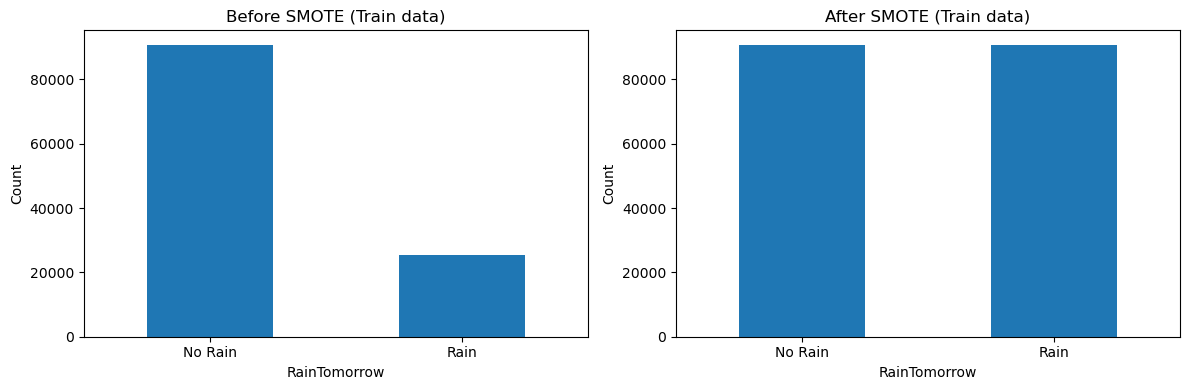

In [12]:
### Class Balancing only on Train Data
print("\nBalancing classes with SMOTE (just on Train data)...")
print(f"Before SMOTE - Train class distribution:\n{y_train.value_counts()}")
print(f"Before SMOTE - Train class ratio: {y_train.value_counts(normalize=True)}")

sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_reduced, y_train)

print(f"\nAfter SMOTE - Train class distribution:\n{y_train_balanced.value_counts()}")
print(f"After SMOTE - Train class ratio:\n{y_train_balanced.value_counts(normalize=True)}")

# Visualize balancing
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

y_train.value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title("Before SMOTE (Train data)")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(['No Rain', 'Rain'], rotation=0)

y_train_balanced.value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title("After SMOTE (Train data)")
axes[1].set_ylabel("Count")
axes[1].set_xticklabels(['No Rain', 'Rain'], rotation=0)

plt.tight_layout()
plt.show()


## PCA


=== PCA - Dimensionality Reduction ===

Number of features before PCA: 60


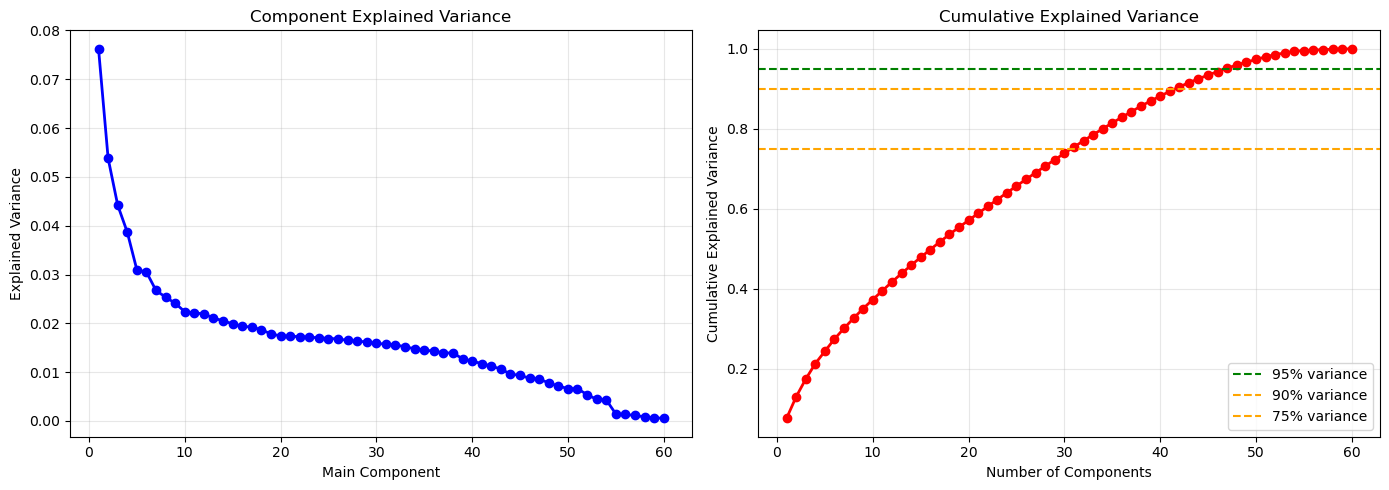


 PCA: 75% variance threshold
   Number of components: 31
   Reduction: 60 → 31 features
   Reduction rate: 48.3%
   Variance retained: 75%

   We sacrifice 25% of variance to reduce dimensionality!

Shape after PCA - Train: (181362, 31), Test: (29045, 31)


In [13]:

# ============================================================================
# PCA
# ============================================================================
print("\n" + "="*70)
print("=== PCA - Dimensionality Reduction ===")
print("="*70)

print(f"\nNumber of features before PCA: {X_train_balanced.shape[1]}")

# Standardize all features for PCA (already done but we're making sure)
scaler_pca = StandardScaler()
X_train_scaled_pca = scaler_pca.fit_transform(X_train_balanced)
X_test_scaled_pca = scaler_pca.transform(X_test_reduced)

# Explained analysis of variance to choose the number of components
pca_full = PCA()
pca_full.fit(X_train_scaled_pca)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Visualizing the explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graph 1 Explained Variance
axes[0].plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
             pca_full.explained_variance_ratio_, 'bo-', linewidth=2, markersize=6)
axes[0].set_xlabel('Main Component')
axes[0].set_ylabel('Explained Variance')
axes[0].set_title('Component Explained Variance')
axes[0].grid(True, alpha=0.3)

# Graph 2 Cumulative Explained Variance
axes[1].plot(range(1, len(cumulative_variance) + 1), 
             cumulative_variance, 'ro-', linewidth=2, markersize=6)
axes[1].axhline(y=0.95, color='g', linestyle='--', label='95% variance')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% variance')
axes[1].axhline(y=0.75, color='orange', linestyle='--', label='75% variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find the number of components for 75% variance
n_components_75 = np.argmax(cumulative_variance >= 0.75) + 1

print(f"\n PCA: 75% variance threshold")
print(f"   Number of components: {n_components_75}")
print(f"   Reduction: {X_train_balanced.shape[1]} → {n_components_75} features")
print(f"   Reduction rate: {(1 - n_components_75/X_train_balanced.shape[1])*100:.1f}%")
print(f"   Variance retained: 75%")
print(f"\n   We sacrifice 25% of variance to reduce dimensionality!")

# Apply PCA with 75% variance
pca = PCA(n_components=n_components_75, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled_pca)
X_test_pca = pca.transform(X_test_scaled_pca)

print(f"\nShape after PCA - Train: {X_train_pca.shape}, Test: {X_test_pca.shape}")




## Model Implementation

In [14]:

# ============================================================================
# Model Implementation
# ============================================================================
print("\n" + "="*70)
print("=== Model Training ===")
print("="*70)



=== Model Training ===


### Logistic Regression

In [15]:

### 1. Logistic Regression
print("\n1. Training Logistic Regression...")
model_log = LogisticRegression(max_iter=1000, random_state=42)
model_log.fit(X_train_balanced, y_train_balanced)
print("✓ Logistic Regression entraîné!")



1. Training Logistic Regression...
✓ Logistic Regression entraîné!


### K-Nearest Neighbors (KNN)

In [16]:

### 2. KNN 
print("\n2. Training KNN Original (high dimensionality), 60 components...")
knn_original = KNeighborsClassifier()
param_grid_original = {'n_neighbors': [5, 7, 9, 11]}

grid_search_original = GridSearchCV(knn_original, param_grid_original, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_original.fit(X_train_balanced, y_train_balanced)

print(f"Best k (Original): {grid_search_original.best_params_['n_neighbors']}")
print(f"Best CV score (Original): {grid_search_original.best_score_:.4f}")

best_k_original = grid_search_original.best_params_['n_neighbors']
model_knn_original = KNeighborsClassifier(n_neighbors=best_k_original)
model_knn_original.fit(X_train_balanced, y_train_balanced)
print(f"KNN Original trained with k={best_k_original}!")



2. Training KNN Original (high dimensionality), 60 components...
Best k (Original): 5
Best CV score (Original): 0.8468
KNN Original trained with k=5!


### K-Nearest Neighbors (KNN) With PCA

In [17]:

### 3. KNN with PCA 
print("\n3. Training KNN with PCA (Dimensionality reduction, to 31 components)...")
knn_pca = KNeighborsClassifier()
param_grid_pca = {'n_neighbors': [5, 7, 9, 11]}

grid_search_pca = GridSearchCV(knn_pca, param_grid_pca, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_pca.fit(X_train_pca, y_train_balanced)

print(f"Best k (PCA): {grid_search_pca.best_params_['n_neighbors']}")
print(f"Best CV score (PCA): {grid_search_pca.best_score_:.4f}")



3. Training KNN with PCA (Dimensionality reduction, to 31 components)...
Best k (PCA): 5
Best CV score (PCA): 0.8206


## Visualisation comparison

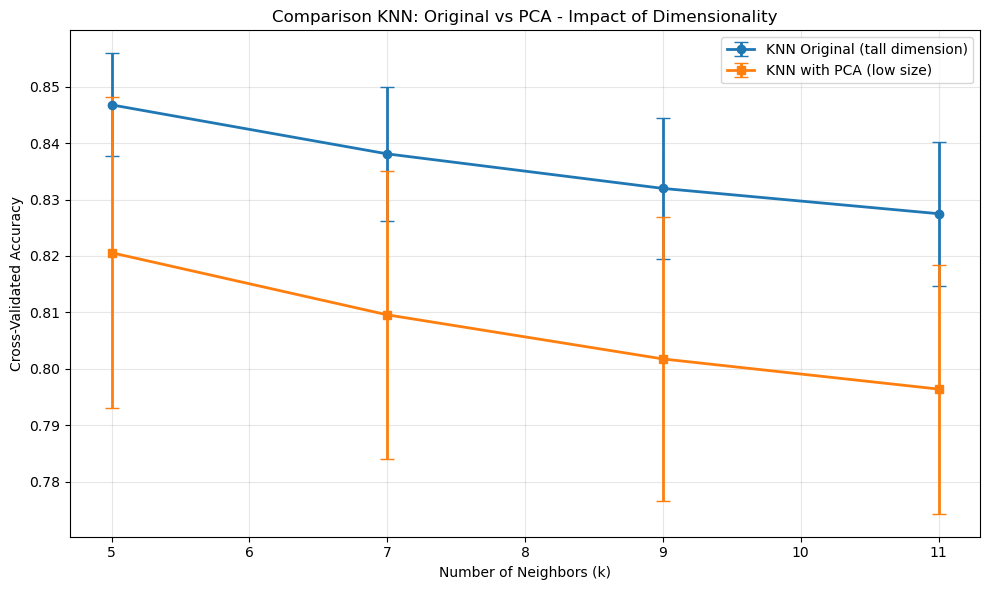

KNN with PCA trained with k=5


In [18]:

# Visualisation comparison GridSearch
results_original = pd.DataFrame(grid_search_original.cv_results_)
results_pca = pd.DataFrame(grid_search_pca.cv_results_)

plt.figure(figsize=(10, 6))
plt.errorbar(results_original['param_n_neighbors'].astype(int), 
             results_original['mean_test_score'],
             yerr=results_original['std_test_score'],
             marker='o', capsize=5, linewidth=2, label='KNN Original (tall dimension)')
plt.errorbar(results_pca['param_n_neighbors'].astype(int), 
             results_pca['mean_test_score'],
             yerr=results_pca['std_test_score'],
             marker='s', capsize=5, linewidth=2, label='KNN with PCA (low size)')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Comparison KNN: Original vs PCA - Impact of Dimensionality")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_k_pca = grid_search_pca.best_params_['n_neighbors']
model_knn_pca = KNeighborsClassifier(n_neighbors=best_k_pca)
model_knn_pca.fit(X_train_pca, y_train_balanced)
print(f"KNN with PCA trained with k={best_k_pca}")


## Model Evaluation

In [29]:

# ============================================================================
# Model Evaluation
# ============================================================================
print("\n" + "="*70)
print("=== Evaluating Models on Data Test ===")
print("="*70)

# Prédictions
y_pred_log = model_log.predict(X_test_reduced)
y_prob_log = model_log.predict_proba(X_test_reduced)[:, 1]

y_pred_knn_original = model_knn_original.predict(X_test_reduced)
y_prob_knn_original = model_knn_original.predict_proba(X_test_reduced)[:, 1]

y_pred_knn_pca = model_knn_pca.predict(X_test_pca)
y_prob_knn_pca = model_knn_pca.predict_proba(X_test_pca)[:, 1]

# Résultats détaillés
print("\n" + "="*50)
print("Logistic Regression - Test Data")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_log):.4f}")
print(f"Recall: {classification_report(y_test, y_pred_log, output_dict=True)['1']['recall']:.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_log):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_log):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))

print("\n" + "="*50)
print("KNN Original (high dimensionality) - Test Data")
print("="*50)
print(f"Dimensions: {X_train_balanced.shape[1]} features")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn_original):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_knn_original):.4f}")
print(f"Recall: {classification_report(y_test, y_pred_knn_original, output_dict=True)['1']['recall']:.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_knn_original):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_knn_original):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn_original))

print("\n" + "="*50)
print("KNN with PCA (low dimensionality), We are trying to reduce the dimensionality - Test Data")
print("="*50)
print(f"Dimensions: {X_train_pca.shape[1]} composantes principales")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn_pca):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_knn_pca):.4f}")
print(f"Recall: {classification_report(y_test, y_pred_knn_pca, output_dict=True)['1']['recall']:.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_knn_pca):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_knn_pca):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn_pca))



=== Evaluating Models on Data Test ===

Logistic Regression - Test Data
Accuracy: 0.7822
Precision: 0.5025
Recall: 0.7687
F1-Score: 0.6078
ROC-AUC: 0.8603

Confusion Matrix:
[[17820  4851]
 [ 1474  4900]]

KNN Original (high dimensionality) - Test Data
Dimensions: 60 features
Accuracy: 0.7355
Precision: 0.4407
Recall: 0.7625
F1-Score: 0.5585
ROC-AUC: 0.8088

Confusion Matrix:
[[16502  6169]
 [ 1514  4860]]

KNN with PCA (low dimensionality), We are trying to reduce the dimensionality - Test Data
Dimensions: 31 composantes principales
Accuracy: 0.7484
Precision: 0.4424
Recall: 0.5626
F1-Score: 0.4953
ROC-AUC: 0.7491

Confusion Matrix:
[[18151  4520]
 [ 2788  3586]]


## Models comparison

### Graph Dimension 


=== Models Comparison ===

=== Comparative table ===
                              Model  Dimensions  Accuracy  Precision   Recall  F1-Score  ROC-AUC
                Logistic Regression          60  0.782234   0.502513 0.768748  0.607752 0.860287
KNN Original (high dimensionality.)          60  0.735479   0.440656 0.762473  0.558524 0.808774
 KNN with PCA (low dimensionality.)          31  0.748390   0.442388 0.562598  0.495304 0.749103

 KNN Improvement with PCA vs Original: +1.76%


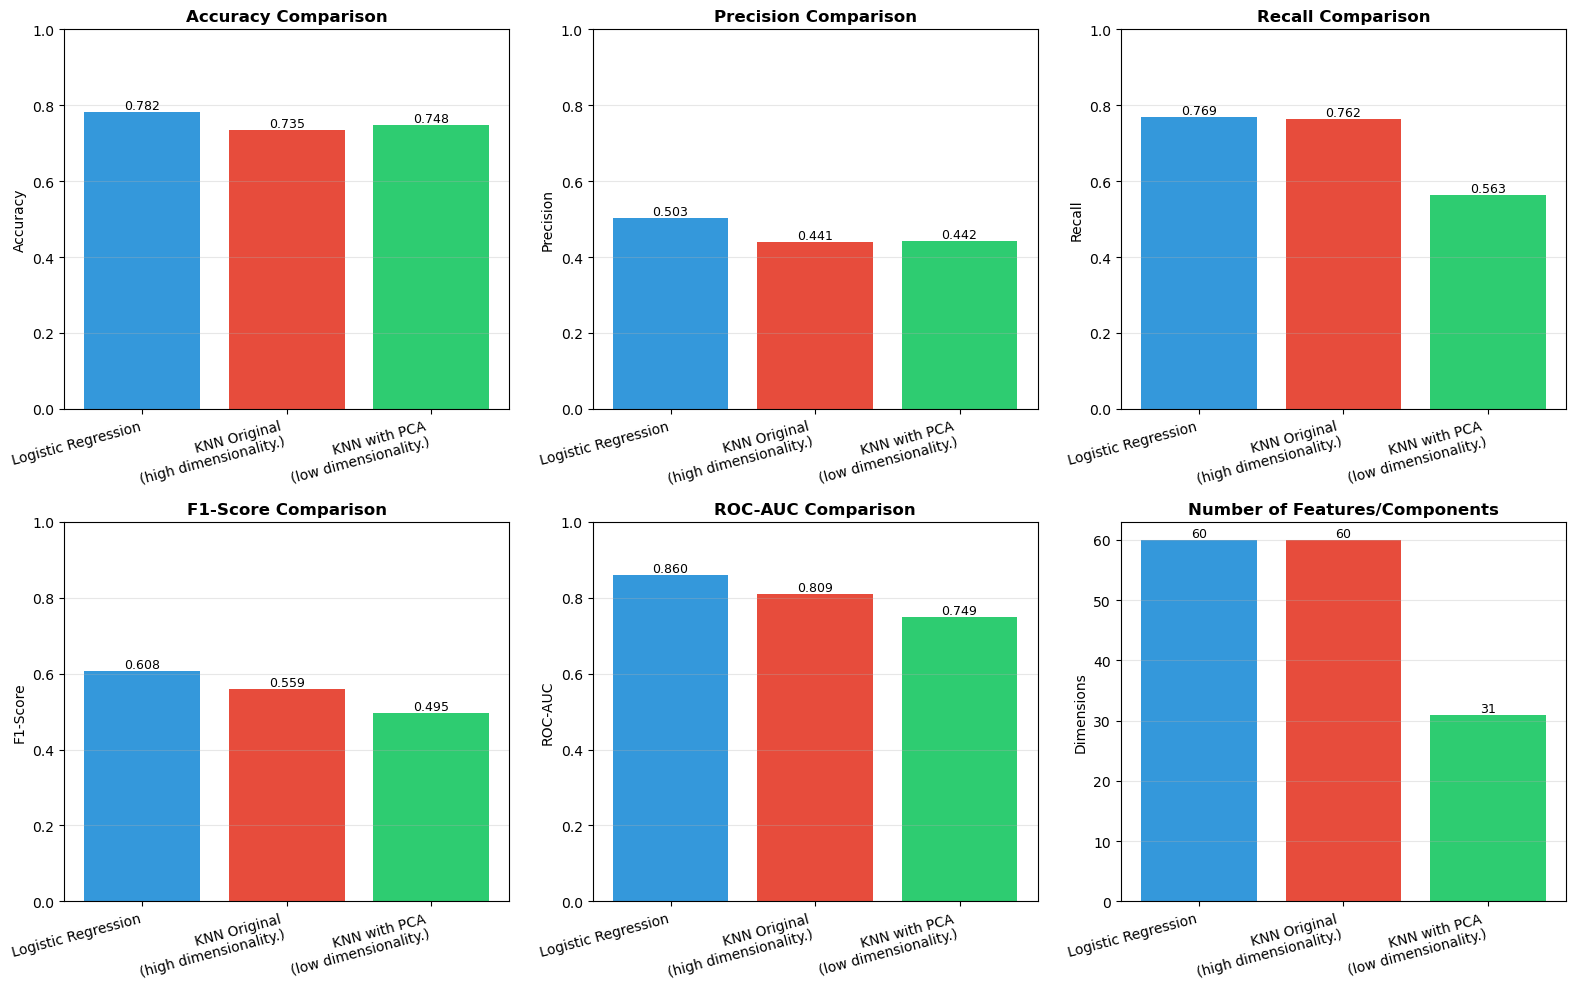

In [20]:

# ============================================================================
# Models Comparison
# ============================================================================
print("\n" + "="*70)
print("=== Models Comparison ===")
print("="*70)

models = {
    "Logistic Regression": (y_pred_log, y_prob_log),
    "KNN Original\n(high dimensionality.)": (y_pred_knn_original, y_prob_knn_original),
    "KNN with PCA\n(low dimensionality.)": (y_pred_knn_pca, y_prob_knn_pca)
}

# Collecte des métriques
comparison_data = {
    'Model': [],
    'Dimensions': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC-AUC': []
}

dims = [X_train_balanced.shape[1], X_train_balanced.shape[1], X_train_pca.shape[1]]
model_names = list(models.keys())

for idx, (name, (preds, probs)) in enumerate(models.items()):
    comparison_data['Model'].append(name.replace('\n', ' '))
    comparison_data['Dimensions'].append(dims[idx])
    comparison_data['Accuracy'].append(accuracy_score(y_test, preds))
    comparison_data['Precision'].append(precision_score(y_test, preds))
    report = classification_report(y_test, preds, output_dict=True)
    comparison_data['Recall'].append(report['1']['recall'])
    comparison_data['F1-Score'].append(f1_score(y_test, preds))
    comparison_data['ROC-AUC'].append(roc_auc_score(y_test, probs))

results_df = pd.DataFrame(comparison_data)
print("\n=== Comparative table ===")
print(results_df.to_string(index=False))

# Calcul de l'amélioration
improvement = ((comparison_data['Accuracy'][2] - comparison_data['Accuracy'][1]) / 
               comparison_data['Accuracy'][1] * 100)
print(f"\n KNN Improvement with PCA vs Original: {improvement:+.2f}%")

# Visualisations comparatives
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    values = results_df[metric].values
    bars = ax.bar(range(len(model_names)), values, color=colors)
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels(model_names, rotation=15, ha='right')
    ax.set_title(f"{metric} Comparison", fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Ajouter les valeurs
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Graphique des dimensions
ax = axes[1, 2]
bars = ax.bar(range(len(model_names)), results_df['Dimensions'].values, color=colors)
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.set_title("Number of Features/Components", fontweight='bold')
ax.set_ylabel("Dimensions")
ax.grid(True, alpha=0.3, axis='y')

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Confusion matrics and classification reports

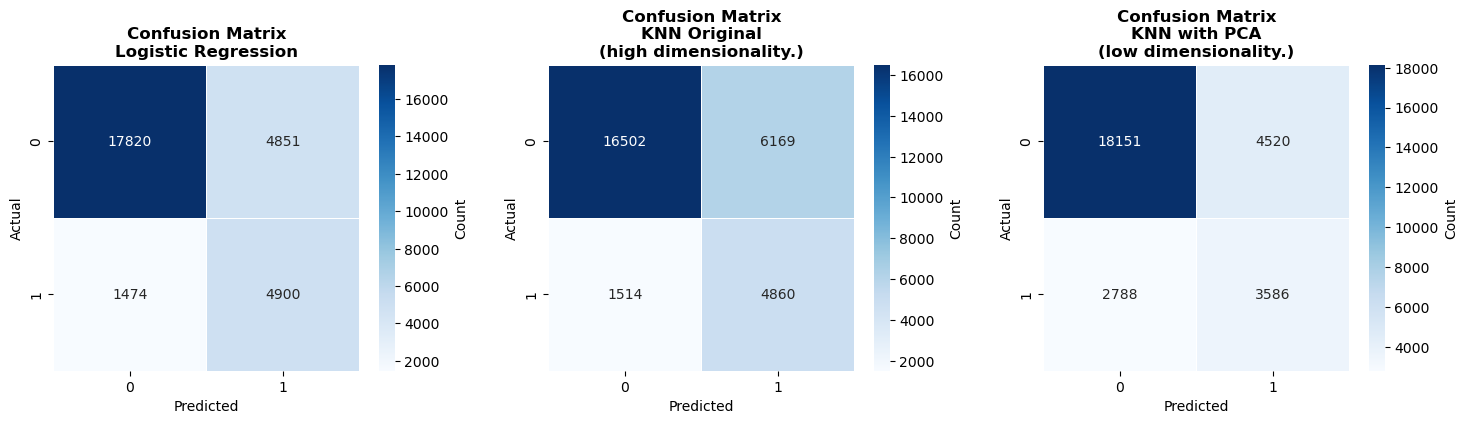

In [21]:

## Confusion matrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, (preds, _)) in enumerate(models.items()):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', linewidths=0.5, square=True, 
                cmap='Blues', ax=axes[idx], cbar_kws={'label': 'Count'})
    axes[idx].set_title(f"Confusion Matrix\n{name}", fontweight='bold')
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

plt.tight_layout()
plt.show()


## ROC Curve Comparison


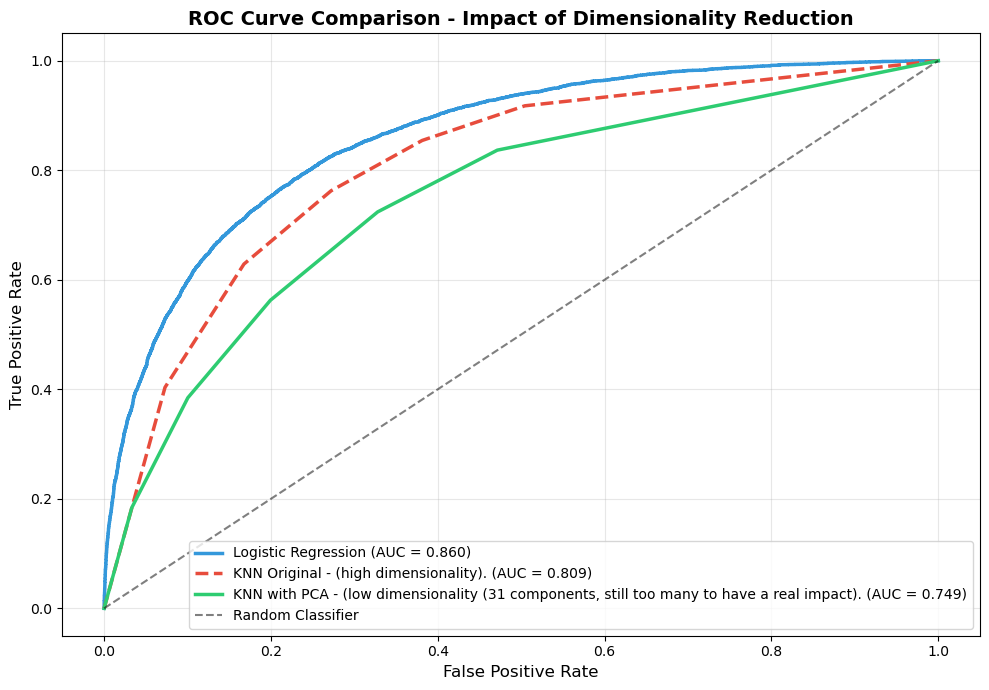

In [22]:

# Curve ROC
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_knn_original, tpr_knn_original, _ = roc_curve(y_test, y_prob_knn_original)
fpr_knn_pca, tpr_knn_pca, _ = roc_curve(y_test, y_prob_knn_pca)

plt.figure(figsize=(10, 7))
plt.plot(fpr_log, tpr_log, 
         label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_log):.3f})', 
         linewidth=2.5, color='#3498db')
plt.plot(fpr_knn_original, tpr_knn_original, 
         label=f'KNN Original - (high dimensionality). (AUC = {roc_auc_score(y_test, y_prob_knn_original):.3f})', 
         linewidth=2.5, color='#e74c3c', linestyle='--')
plt.plot(fpr_knn_pca, tpr_knn_pca, 
         label=f'KNN with PCA - (low dimensionality (31 components, still too many to have a real impact). (AUC = {roc_auc_score(y_test, y_prob_knn_pca):.3f})', 
         linewidth=2.5, color='#2ecc71')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve Comparison - Impact of Dimensionality Reduction", 
          fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cross-Validation



=== Cross-Validation (5-Fold) ===
Logistic Regression CV - Mean: 0.7791, Std: 0.0034
KNN Original CV - Mean: 0.8468, Std: 0.0091
KNN with PCA CV - Mean: 0.8206, Std: 0.0275


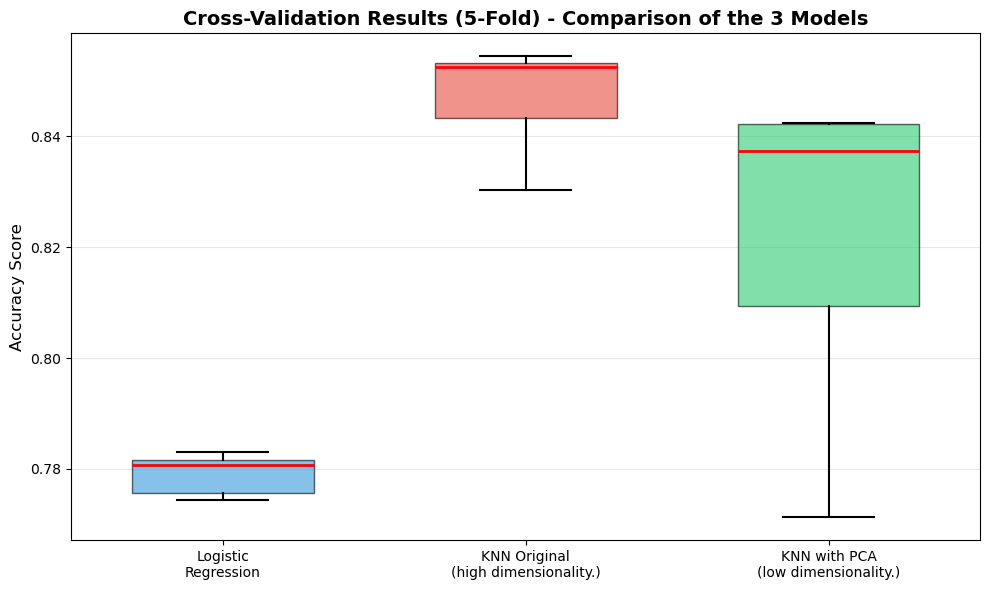

In [23]:
# Cross-Validation
print("\n" + "="*70)
print("=== Cross-Validation (5-Fold) ===")
print("="*70)

cv_log = cross_val_score(model_log, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
cv_knn_original = cross_val_score(model_knn_original, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
cv_knn_pca = cross_val_score(model_knn_pca, X_train_pca, y_train_balanced, cv=5, scoring='accuracy')

print(f"Logistic Regression CV - Mean: {cv_log.mean():.4f}, Std: {cv_log.std():.4f}")
print(f"KNN Original CV - Mean: {cv_knn_original.mean():.4f}, Std: {cv_knn_original.std():.4f}")
print(f"KNN with PCA CV - Mean: {cv_knn_pca.mean():.4f}, Std: {cv_knn_pca.std():.4f}")

# Visualisation Cross-Validation
plt.figure(figsize=(10, 6))
cv_results = [cv_log, cv_knn_original, cv_knn_pca]
positions = [1, 2, 3]
labels = ['Logistic\nRegression', 'KNN Original\n(high dimensionality.)', 'KNN with PCA\n(low dimensionality.)']

bp = plt.boxplot(cv_results, positions=positions, widths=0.6, patch_artist=True,
                 tick_labels=labels,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5))

# Colorer différemment chaque boîte
colors = ['#3498db', '#e74c3c', '#2ecc71']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Cross-Validation Results (5-Fold) - Comparison of the 3 Models', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


## Analysis: Feature importance


=== Feature importance (Logistic Regression) ===

Top 10 Most Important Features:
Humidity3pm       1.089223
WindGustSpeed     0.675001
WindDir3pm_SW    -0.591129
WindDir9am_ESE   -0.512844
WindDir3pm_SSW   -0.493020
WindDir9am_S     -0.486356
WindDir3pm_SSE   -0.467122
WindDir9am_SE    -0.464311
WindDir9am_SSE   -0.461610
WindDir3pm_S     -0.427978
dtype: float64


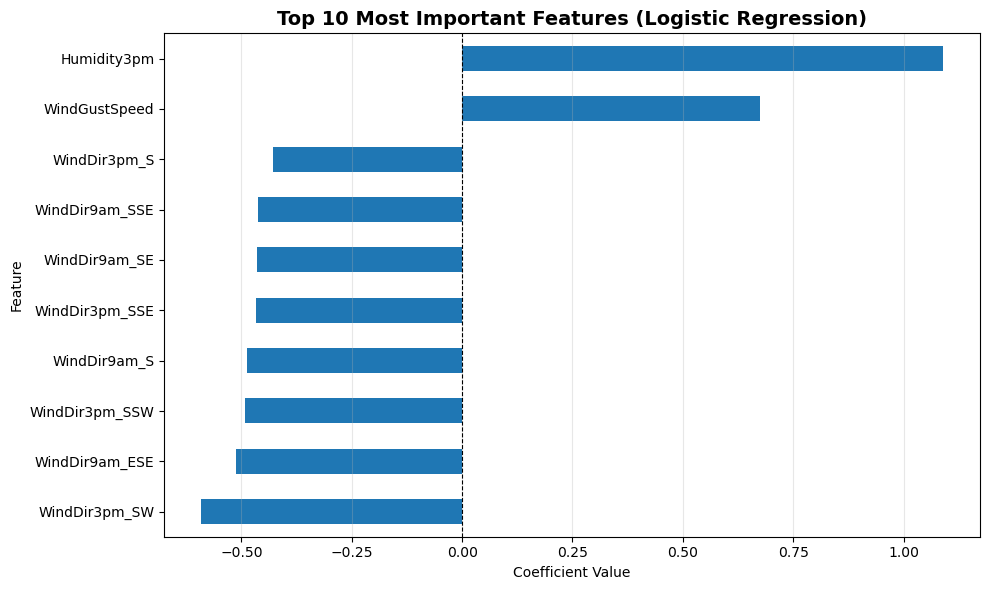

In [24]:

# Feature importance (Logistic Regression)
print("\n" + "="*70)
print("=== Feature importance (Logistic Regression) ===")
print("="*70)

feature_importance = pd.Series(
    model_log.coef_[0],
    index=X_train_balanced.columns
).sort_values(key=abs, ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Visualization
top_features = feature_importance.head(10)
colors_importance = top_features.apply(lambda x: '#e74c3c' if x < 0 else '#2ecc71')

plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh')
plt.title("Top 10 Most Important Features (Logistic Regression)", 
          fontsize=14, fontweight='bold')
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


